Import needed libraries

In [1]:
import cv2
import torch
from Encoders import TimeToFirstSpikeEncoding, GaussianEncoding, PoissonEncoding
from matplotlib import pyplot as plt
from pymonntorch import *
import numpy as np
from timeRes import TimeResolution
from current import *
from lif import LIF, InputPattern
from synapse import *
from connections import Connections
from learning import STDP, RSTDP

In [2]:
# read an image and convert it to torch tensor
def image_to_vec(address, size=(10, 10)):
    img = cv2.imread(address)
    img = cv2.resize(img, (size[0], size[1]))
    img = torch.from_numpy(img)
    img = img.sum(2)//3

    return img


def show_image(img):
    plt.imshow(img, cmap='gray')  
    plt.show()


In [3]:
def raster_plot(spikes, fsize=(5,5)):
    
    plt.figure(figsize=fsize)
    plt.xlim(0, len(spikes))
    s_spikes = torch.nonzero(spikes)
    plt.scatter(s_spikes[:,0], s_spikes[:,1], s=2, c='darkviolet')
    
        
    plt.xlabel("Time")
    plt.ylabel("Neurons")
    plt.show()

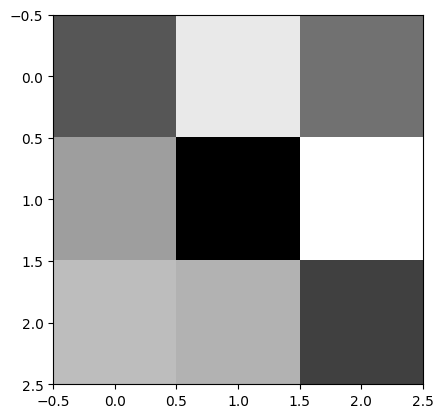

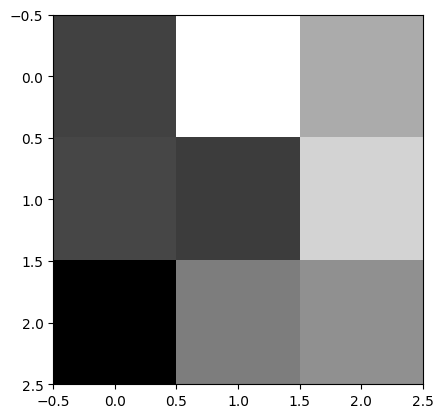

In [4]:
img1 = image_to_vec('images/barb.tif', (3, 3))
show_image(img1)
img2 = image_to_vec('images/circles.tif', (3, 3))
show_image(img2)
img3 = image_to_vec('images/lena1.tif', (3, 3))
show_image(img3)
img4 = image_to_vec('images/library.tif', (50, 50))
show_image(img4)


## Time To First Spike Encoding

In [18]:
ttfs1 = TimeToFirstSpikeEncoding(img1, 200)
ttfs2 = TimeToFirstSpikeEncoding(img2, 200)
ttfs3 = TimeToFirstSpikeEncoding(img3, 200)
ttfs4 = TimeToFirstSpikeEncoding(img4, 200)

ttfs_spikes1 = ttfs1.encode()
ttfs_spikes2 = ttfs2.encode()
ttfs_spikes3 = ttfs3.encode()
ttfs_spikes4 = ttfs4.encode()

raster_plot(ttfs_spikes1)
raster_plot(ttfs_spikes2)
raster_plot(ttfs_spikes3)
raster_plot(ttfs_spikes4)

NameError: name 'img2' is not defined

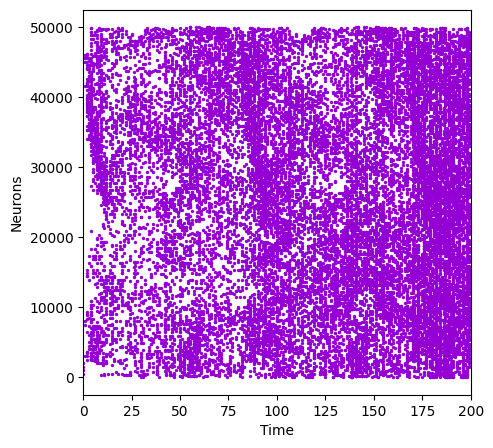

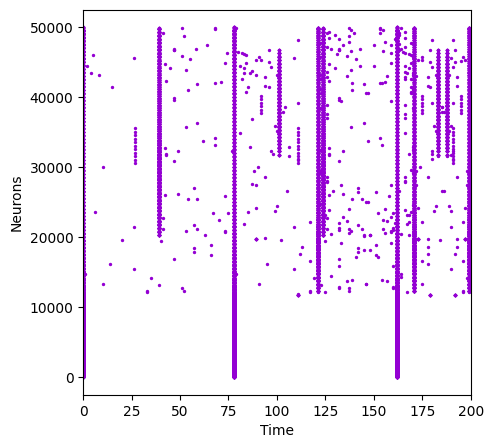

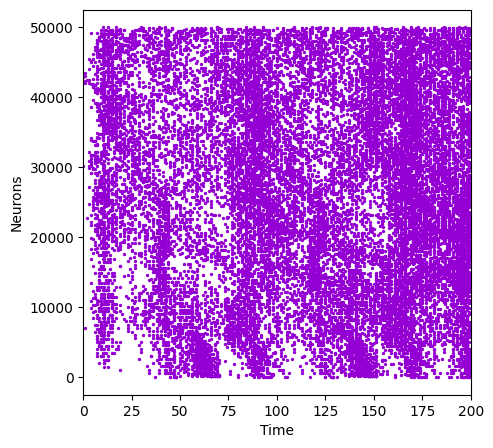

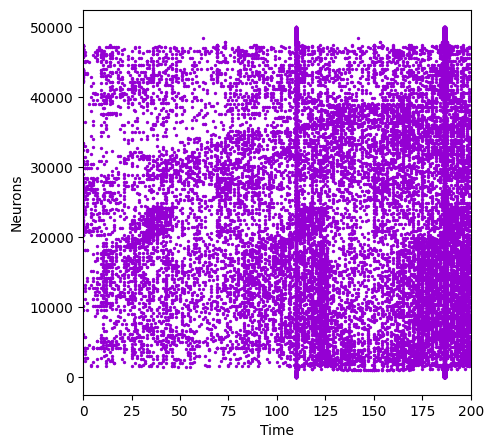

In [ ]:
ge1 = GaussianEncoding(img1, 200, 5)
ge2 = GaussianEncoding(img2, 200, 5)
ge3 = GaussianEncoding(img3, 200, 5)
ge4 = GaussianEncoding(img4, 200, 5)

ge_spikes1 = ge1.encode()
ge_spikes2 = ge2.encode()
ge_spikes3 = ge3.encode()
ge_spikes4 = ge4.encode()

raster_plot(ge_spikes1)
raster_plot(ge_spikes2)
raster_plot(ge_spikes3)
raster_plot(ge_spikes4)

### Poisson Encoding

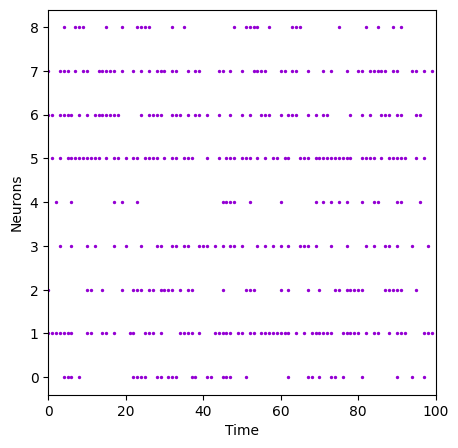

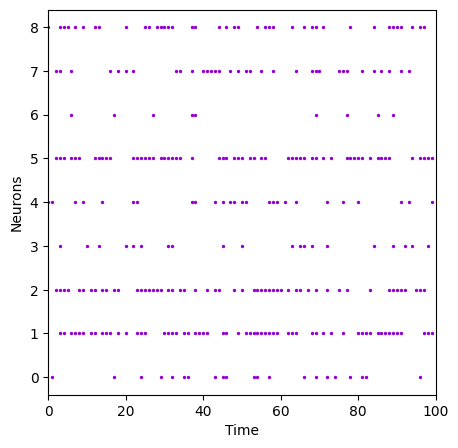

In [5]:
pe1 = PoissonEncoding(img1, 100, 100)
pe2 = PoissonEncoding(img2, 100, 100)
pe3 = PoissonEncoding(img3, 100, 100)
pe4 = PoissonEncoding(img4, 100, 100)

pe_spikes1 = pe1.encode()
pe_spikes2 = pe2.encode()
pe_spikes3 = pe3.encode()
pe_spikes4 = pe4.encode()

raster_plot(pe_spikes1)
raster_plot(pe_spikes2)
raster_plot(pe_spikes3)
raster_plot(pe_spikes4)


In [6]:
def fill_pattern(pattern, n_free, is_right=True):
    pattern = pattern.transpose(-2, 1)
    shape = pattern.shape
    new_pattern = torch.zeros(shape[0]+n_free, shape[1])
    if is_right:
        for i in range(pattern.shape[0]):
            for j in range(pattern.shape[1]):
                new_pattern[i][j] = pattern[i][j] 
    else:
        for i in range(pattern.shape[0]):
            for j in range(pattern.shape[1]):
                new_pattern[i+n_free][j] = pattern[i][j]

    return new_pattern


In [7]:
def noisy_pattern(pattern1, n=300):
    indexesi = [random.randint(0, 99) for _ in range(n)]
    indexesj = [random.randint(0, 8) for _ in range(n)]

    k = 0
    for i in range(n):
        if pattern1[indexesi[k]][indexesj[k]]:
            pattern1[indexesi[k]][indexesj[k]] = False
        else:
            pattern1[indexesi[k]][indexesj[k]] = True
        k += 1

    return pattern1
            

In [8]:
def neg_pat(pattern):
    new_pat = torch.zeros(pattern.shape[0], pattern.shape[1])
    for i in range(pattern.shape[0]):
        for j in range(pattern.shape[1]):
            if pattern[i][j]:
                new_pat[i][j] = 0
            else:
                new_pat[i][j] = 1

    return new_pat

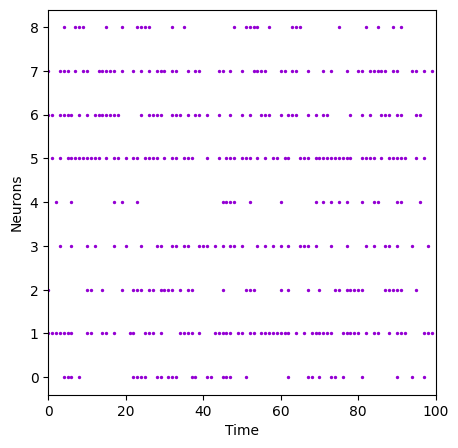

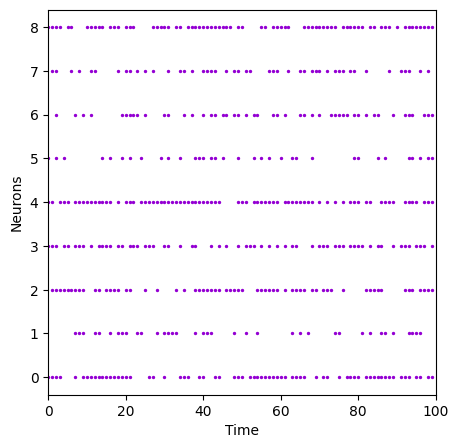

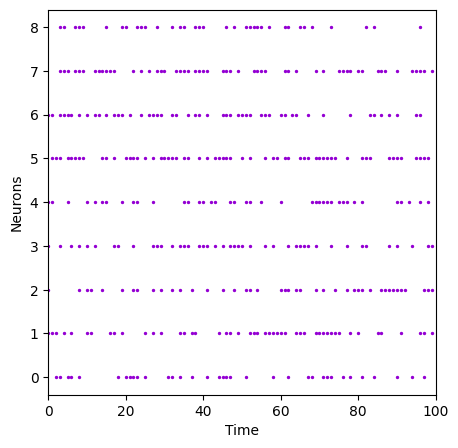

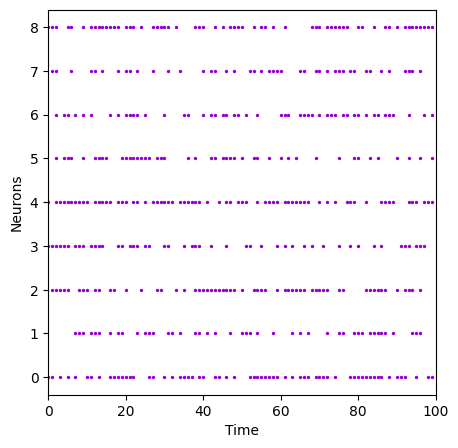

In [10]:
pattern1 = fill_pattern(pe_spikes1, 0)
pattern2 = neg_pat(pe_spikes1)
# pattern2 = pattern2.transpose(-2, 1)
pattern2 = fill_pattern(pattern2, 0, False)
# pattern2 = fill_pattern(pe_spikes3, 9, False)
pattern1 = pattern1.transpose(-2, 1)
pattern2 = pattern2.transpose(-2, 1)
raster_plot(pattern1)
raster_plot(pattern2)
# p1 = pattern1.copy()
# p2 = pattern2.copy()
pattern1 = noisy_pattern(pattern1)
pattern2 = noisy_pattern(pattern2)
raster_plot(pattern1)
raster_plot(pattern2)

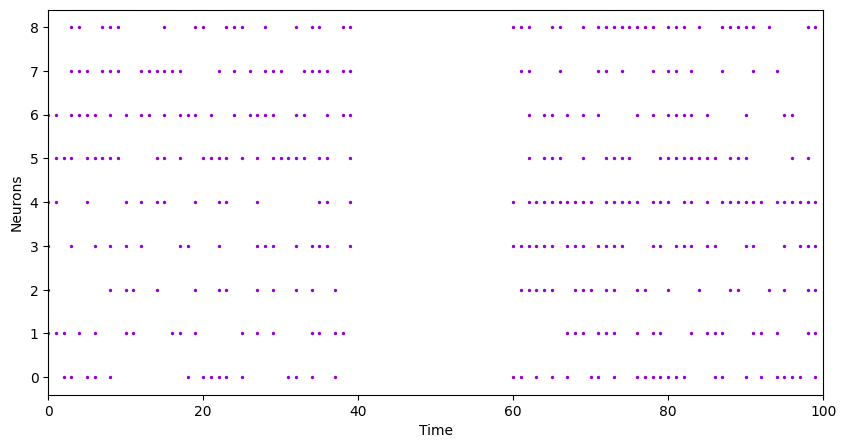

In [11]:
patt = torch.zeros(100, 9)
for i in range(100):
    for j in range(pattern2.shape[1]):
        if i < 40:
            patt[i][j] = pattern1[i][j]
        elif i >= 40 and i < 60:
            patt[i][j] = 0
        else:
            patt[i][j] = pattern2[i-60][j]
raster_plot(patt, fsize=(10, 5))

In [30]:

net = Network(behavior={1: TimeResolution()}, dtype=torch.float64)
input_ng = NeuronGroup(
    9,
    net=net,
    behavior={
        7: InputPattern(pattern=pattern1, pattern2=pattern2, cpt=40, sleep=20, tau_t=1.2),
    },
    tag="inp_NG1",
)


output_ng = NeuronGroup(
    2,
    net=net,
    behavior={
        2: ConstantCurrent(value=0),
        5: InpSyn(),
        7: LIF(
            tau=20,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-35,
            R=5,
            N=2,
        ),
        9: Recorder(variables=["v", "I"], tag="inh_ng1_rec, inh_ng1_recorder"),
        10: EventRecorder("spike", tag="inh_ng1_evrec"),
    },
    tag="out_NG2",
)

connect_inp_out = SynapseGroup(net=net,
                src=input_ng, 
                dst=output_ng, 
                behavior={
                    3: SynFun(),
                    4: RSTDP(lr=[9,10],wd=15, wmin=10, wmax=60,  tau_d=20),
                    5: Connections(def_val=30, type="full"),    
                    11: Recorder(variables=["W"], tag="layers weights"),  
                })


In [31]:
net.initialize()
net.simulate_iterations(100)

Network['Network_1', 'Network'](Neurons: tensor(11)|2 groups, Synapses: tensor(18)|1 groups){1:TimeResolution()}
NeuronGroup['inp_NG1', 'NeuronGroup', 'ng'](9){7:InputPattern(pattern=tensor([[0., 1., 1., 1., 1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1., 0., 0.],
        [1., 1., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 1., 0., 1., 1., 1., 1.],
        [0., 1., 0., 0., 0., 0., 1., 1., 1.],
        [1., 0., 0., 0., 1., 1., 1., 1., 0.],
        [1., 1., 0., 1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 1.],
        [1., 0., 1., 1., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 0., 1., 1.],
        [0., 1., 1., 1., 1., 0., 1., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 1., 0., 1., 1.

733.0348491668701

Text(0, 0.5, 'sosine similarity')

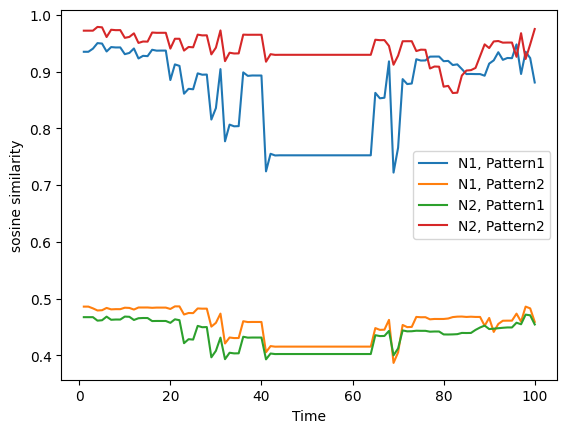

In [43]:
p1s, p2s = [], []
for i in range(pattern1.shape[1]):
    s1, s2 = 0, 0
    for j in range(40):
        if pattern1[j][i] == 1:
            s1 += 1
        if pattern2[j][i] == 1:
            s2 += 1
    p1s.append(s1)
    p2s.append(s2)


net1 = net["W", 0]
res1 = []
res2 = []
res3 = []
res4 = []
for i in range(net1.shape[0]):
    column1 = []  # First column
    column2 = []  # First column
    for j in range(net1.shape[1]):
        column1.append(net1[i][j][0].item())
        column2.append(net1[i][j][1].item())

    dot_product1 = np.dot(column1, p1s)
    dot_product2 = np.dot(column1, p2s)
    dot_product3 = np.dot(column2, p1s)
    dot_product4 = np.dot(column2, p2s)

    magnitude1 = np.linalg.norm(column1)
    magnitudes1 = np.linalg.norm(p1s)
    magnitude2 = np.linalg.norm(column2)
    magnitudes2 = np.linalg.norm(p2s)

    # Calculate cosine similarity
    cosine_similarity1 = dot_product1 / (magnitude1 * magnitudes1)
    cosine_similarity2 = dot_product2 / (magnitude1 * magnitudes2)
    cosine_similarity3 = dot_product3 / (magnitude2 * magnitudes1)
    cosine_similarity4 = dot_product4 / (magnitude2 * magnitudes2)
    
    res1.append(cosine_similarity1)
    res2.append(cosine_similarity2)
    res3.append(cosine_similarity3)
    res4.append(cosine_similarity4)

time = [i for i in range(1, 101)]
plt.plot(time, res1, label="N1, Pattern1")
plt.plot(time, res2, label="N1, Pattern2")
plt.plot(time, res3, label="N2, Pattern1")
plt.plot(time, res4, label="N2, Pattern2")
plt.legend()
plt.xlabel("Time")
plt.ylabel("sosine similarity")


In [ ]:
vars1 = []
vars2 = []
time = [i for i in range(100)]
for i in range(9):
    x = []
    y = []
    for j in range(100):
        x.append(net["W", 0][j][i][0])
        y.append(net["W", 0][j][i][1])
    vars1.append(x)
    vars2.append(y)

print(len(vars1[0]))
plt.figure(figsize=(10, 5))
for i in range(9):
    
    plt.plot(time, vars1[i])
    plt.plot(time, vars2[i])

plt.xlabel("time")
plt.ylabel("weight")
